Using:
    https://gist.github.com/EdwardJRoss/86b31848a7951411de56f10f55e9de4e
    https://forums.fast.ai/t/character-level-language-model/31379
    
Lesson 3 RNN


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


## Language model

Language model with Just Eat data only

In [3]:
df = pd.read_csv('data/after_21_11_2019_meeting_clean.csv')



In [6]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
valid_df = df[~msk]

In [8]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [9]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [10]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [11]:
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=1, mark_fields=False, bs=128)

In [14]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.8)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


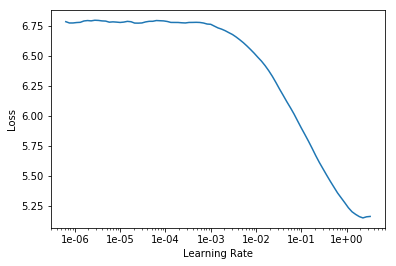

In [15]:
learn.recorder.plot()

In [15]:
learn.freeze()

In [16]:
lr = 1e-1
moms = (0.8,0.7)
scale = (2.6**4)
cycles = 25

In [17]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,4.586734,3.186971,0.143917,00:06
1,3.551581,2.388730,0.304665,00:06
2,2.986395,2.181554,0.361808,00:06
3,2.673569,2.077081,0.397098,00:06
4,2.474318,1.997664,0.420536,00:06
5,2.405106,2.207458,0.377801,00:06
6,2.349890,1.966061,0.426786,00:06
7,2.295150,1.965968,0.427288,00:06
8,2.276107,1.944727,0.429074,00:06
9,2.248946,1.946770,0.430301,00:06


In [18]:
learn.freeze_to(-2)

In [19]:
learn.fit_one_cycle(cycles, slice((lr/2)/(2.6**4),lr/2), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,2.092247,1.820908,0.460882,00:06
1,2.015755,1.755987,0.478348,00:06
2,1.923372,1.661538,0.506931,00:06
3,1.812851,1.562090,0.534353,00:06
4,1.716902,1.668131,0.513047,00:06
5,1.636063,1.439194,0.572489,00:06
6,1.572514,1.401795,0.580357,00:06
7,1.541872,1.395020,0.585391,00:06
8,1.484732,1.344802,0.598504,00:06
9,1.447821,1.370546,0.594587,00:06


In [20]:
learn.freeze_to(-3)
learn.fit_one_cycle(cycles, slice((lr/4)/(2.6**4),lr/4), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.166087,1.231360,0.634833,00:07
1,1.172058,1.229445,0.635502,00:07
2,1.174226,1.229413,0.636016,00:07
3,1.167544,1.229609,0.636373,00:07
4,1.171588,1.228817,0.634866,00:07
5,1.178822,1.230616,0.634955,00:07
6,1.174345,1.227439,0.637790,00:07
7,1.157496,1.228403,0.637165,00:07
8,1.166912,1.229598,0.639520,00:07
9,1.144347,1.223407,0.640368,00:07


In [21]:
learn.unfreeze()
learn.fit_one_cycle(cycles, slice((lr/8)/(2.6**4),lr/8), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.010069,1.222442,0.648158,00:08
1,1.022450,1.224124,0.647690,00:08
2,1.024099,1.223109,0.647545,00:08
3,1.025979,1.223794,0.646998,00:08
4,1.024626,1.225625,0.647009,00:08
5,1.032492,1.229441,0.645982,00:08
6,1.028265,1.227418,0.647065,00:08
7,1.021050,1.231952,0.646853,00:08
8,1.027107,1.227323,0.646942,00:08
9,1.020401,1.229178,0.647009,00:08


In [22]:
TEXT = "bob"
N_WORDS = 1000
N_SENTENCES = 1

In [23]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

bob b y s   b u r g e r s xxbos   t h e   l i m e xxbos   n o o r   l e b a n e s e   r e s t a u r a n t xxbos   s t r e e t   f o o d xxbos   g a s k o ' s   p i z z a xxbos   s o   j o h n ' s   ( s o h o xxbos   t h e   p o t t e r s   d e l i xxbos   t h i r s t y   b i t e s xxbos   t h e   g o l d e n   f r y   f o o d   b a r xxbos   s t o n e h o u s e   r o y a l   c u i s i n e xxbos   d a l l a s   c h i c k e n   &   p i z z a xxbos   s l a r o m a   p i z z a xxbos   h o t   p o i n t xxbos   c a f e   t r u e   -   r a i n b o w   c e n t r a l xxbos   s t a r   p i z z a   &   g r i l l xxbos   b a l o u   c u r r y   &   f a s t   f o o d xxbos   b e n g a l   b a l t i   &   t a n d o o r i xxbos   l a   v i c t o r i a   l t d xxbos   p i z z a   t i m e xxbos   s h a n g h a i   w o k xxbos   k a m s   c h i c k e n   &   p i z z a xxbos   j o h n n y   b o x   p i z z a xxbos   t h e   b a l t i   h o u s e   r e s t a u r a n t xxbos   h u n g r y   h o u s e xxbo

In [46]:
learn.save_encoder('just_eat_enc_bs128_2')